In [99]:
# 3/4 ноутбука - Димина сборка данных, мне было так удобнее

In [100]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

#### **Очистка базового датасета**

Для построения линейных моделей берём только Москву

In [101]:
df_cafes = pd.read_csv('cafes_df_full.csv')
df_cafes = df_cafes[df_cafes['city'] == 'Москва']
df_cafes.head()

,name,type,osm_type,address,cuisine,rating,website,source_tag,lat,lon,dgis_id,dgis_match_name,dgis_address,dgis_point_lat,dgis_point_lon,dgis_general_rating,dgis_general_review_count,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,dgis_rating_raw,dgis_review_count_raw,city
0,Salden's Taphouse,bar,node,"Мясницкая улица, 32/1 с1",NaN,NaN,https://www.saldenstaphouse.ru/taphousemyasnic...,amenity,55.7656,37.6390,70000001083027904.0000,"Salden`s Taphouse, бар","Мясницкая улица, 32 ст1",55.7657,37.6390,4.9000,63.0000,129.0000,4.8000,252.0000,5.0000,29.0000,Москва
1,Центральный рынок,marketplace,node,NaN,NaN,NaN,NaN,amenity,57.1480,65.5429,1830115629597404.0000,"Центральный, продуктовый рынок","улица Герцена, 95",57.1480,65.5431,4.3000,177.0000,1047.0000,4.3000,177.0000,3.3000,8.0000,Москва
2,Пышка,cafe,node,NaN,NaN,NaN,NaN,amenity,57.1467,65.5444,1830115630036686.0000,"Пышечная, кофейня","улица Герцена, 97",57.1472,65.5433,4.6000,653.0000,753.0000,4.6000,653.0000,3.8000,21.0000,Москва
3,Com,cafe,node,NaN,vietnamese,NaN,NaN,amenity,55.7683,37.6446,70000001093465152.0000,"Com 1989, кафе вьетнамской кухни","Мясницкая улица, 46 ст1",55.7683,37.6447,3.5000,7.0000,12.0000,4.5000,164.0000,NaN,NaN,Москва
4,Шоколадница,cafe,node,NaN,coffee_shop,NaN,https://shoko.ru/,amenity,55.7388,37.6530,4504127908433931.0000,"Шоколадница, кофейня","улица Большие Каменщики, 2",55.7388,37.6529,2.4000,109.0000,170.0000,3.1000,10899.0000,2.7000,3.0000,Москва


Избавимся от лишних колонок, которые не несут какого-то полезного смысла или являются мусорными

In [102]:
df_cafes.columns

Index(['name', 'type', 'osm_type', 'address', 'cuisine', 'rating', 'website',
       'source_tag', 'lat', 'lon', 'dgis_id', 'dgis_match_name',
       'dgis_address', 'dgis_point_lat', 'dgis_point_lon',
       'dgis_general_rating', 'dgis_general_review_count',
       'dgis_general_review_count_with_stars', 'dgis_org_rating',
       'dgis_org_review_count', 'dgis_rating_raw', 'dgis_review_count_raw',
       'city'],
      dtype='object')

In [103]:
df_cafes.drop(columns = ['address', 'rating', 'source_tag', 'dgis_match_name',
                         'dgis_address', 'dgis_point_lat', 'dgis_point_lon',
                         'dgis_general_review_count', 'dgis_rating_raw',
                         'dgis_review_count_raw', 'osm_type', 'dgis_id'], inplace = True)


Почистим строки от случайно спарсенных объектов из других городов с помощью координат, воспользовавшись geopandas

In [104]:
# забираем полигон Москвы из OSM
moscow = ox.geocode_to_gdf("Moscow, Russia")
moscow_poly = moscow.loc[0, "geometry"]

# делаем GeoDataFrame по кафе
points = gpd.GeoDataFrame(
    df_cafes.copy(),
    geometry=gpd.points_from_xy(df_cafes["lon"], df_cafes["lat"]),
    crs="EPSG:4326",
)

# проверяем, лежит ли точка внутри Москвы
points["is_moscow"] = points.within(moscow_poly)

# флаг в исходный df
df_cafes["city"] = points["is_moscow"].map({True: "Москва", False: "не Москва"})
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city
0,Salden's Taphouse,bar,NaN,https://www.saldenstaphouse.ru/taphousemyasnic...,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва
1,Центральный рынок,marketplace,NaN,NaN,57.1480,65.5429,4.3000,1047.0000,4.3000,177.0000,не Москва
2,Пышка,cafe,NaN,NaN,57.1467,65.5444,4.6000,753.0000,4.6000,653.0000,не Москва
3,Com,cafe,vietnamese,NaN,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва
4,Шоколадница,cafe,coffee_shop,https://shoko.ru/,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва
...,...,...,...,...,...,...,...,...,...,...,...
9769,Рынок,marketplace,NaN,NaN,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва
9770,Грин Клаб,restaurant,NaN,https://www.greenklub.ru/,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва
9771,Яковлевский рынок,marketplace,NaN,NaN,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва
9772,Акулово,restaurant,NaN,NaN,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва


In [105]:
# оставляем только МСК
df_cafes = df_cafes[df_cafes['city'] == 'Москва'].reset_index(drop = True)
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city
0,Salden's Taphouse,bar,NaN,https://www.saldenstaphouse.ru/taphousemyasnic...,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва
1,Com,cafe,vietnamese,NaN,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва
2,Шоколадница,cafe,coffee_shop,https://shoko.ru/,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва
3,Тануки,restaurant,japanese,https://tanukifamily.ru/tanuki/,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва
4,Вареничная №1,restaurant,russian,http://www.varenichnaya.ru,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва
...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,NaN,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва
9214,Грин Клаб,restaurant,NaN,https://www.greenklub.ru/,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва
9215,Яковлевский рынок,marketplace,NaN,NaN,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва
9216,Акулово,restaurant,NaN,NaN,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва


1. Сперва создадим фичи, которые можно извлечь из данных самих кафешек

In [106]:
df_cafes["website"] = df_cafes["website"].where(df_cafes["website"].isna(), 1)
df_cafes["website"].fillna(0, inplace = True)
df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва


In [107]:
# Добавим сразу признак бренда. Если заведений с одинаковым названием и разными координатами > 1, то это сеть заведений и brand = name
# Если же нет, то бренда нет и это одиночное заведение brand = single
def get_brand_feature(df):
    df["coord"] = list(zip(df["lon"], df["lat"]))
    coord_counts = df.groupby("name")["coord"].transform("nunique")
    df["brand"] = np.where(coord_counts > 1, df["name"], "single")
    df.drop(columns=["coord"], inplace=True)
    return df

df_cafes = get_brand_feature(df_cafes)
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1
...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single
9215,Яковлевский рынок,marketplace,NaN,0,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва,single
9216,Акулово,restaurant,NaN,0,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва,single


In [108]:
# добавим метрику количества конкурентов в радиусе 100м, 500м, 1000м

gdf = gpd.GeoDataFrame(
    df_cafes.copy(),
    geometry=gpd.points_from_xy(df_cafes['lon'], df_cafes['lat']),
    crs="EPSG:4326"
)

# в метры
gdf = gdf.to_crs(epsg=32637)

def count_competitors(gdf, radius_m, cuisine_mode):
    if cuisine_mode not in ("direct", "indirect"):
        raise ValueError("cuisine_mode must be 'direct' or 'indirect'")

    # буфер вокруг каждой точки
    buf = gdf.copy()
    buf["geometry"] = buf.geometry.buffer(radius_m)

    right = gdf[["geometry", "cuisine"]].copy()
    right["nbr_id"] = right.index

    # пространственный self-join
    joined = gpd.sjoin(
        buf[["geometry", "cuisine"]],
        right,
        how="left",
        predicate="contains",
        lsuffix="src",
        rsuffix="nbr"
    )


    joined = joined[joined.index != joined["nbr_id"]]

    if cuisine_mode == "direct":
        # только такая же кухня, как у текущей точки
        mask = joined["cuisine_src"] == joined["cuisine_nbr"]
    else:
        # только отличающаяся кухня
        mask = joined["cuisine_src"] != joined["cuisine_nbr"]

    filtered = joined[mask]

    # считаем количество соседей по каждой исходной точке
    counts = filtered.groupby(level=0).size()

    counts = counts.reindex(gdf.index, fill_value=0)

    return counts


gdf["direct_competitors_500m"]  = count_competitors(gdf, radius_m=500,  cuisine_mode="direct")
gdf["direct_competitors_1000m"] = count_competitors(gdf, radius_m=1000, cuisine_mode="direct")
gdf["direct_competitors_100m"]  = count_competitors(gdf, radius_m=100,  cuisine_mode="direct")

gdf["indirect_competitors_500m"]  = count_competitors(gdf, radius_m=500,  cuisine_mode="indirect")
gdf["indirect_competitors_1000m"] = count_competitors(gdf, radius_m=1000, cuisine_mode="indirect")
gdf["indirect_competitors_100m"]  = count_competitors(gdf, radius_m=100,  cuisine_mode="indirect")

df_cafes = pd.DataFrame(gdf.drop(columns="geometry"))
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single,0,0,0,0,0,0
9215,Яковлевский рынок,marketplace,NaN,0,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва,single,0,0,0,0,0,0
9216,Акулово,restaurant,NaN,0,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва,single,0,0,0,0,0,0


In [109]:
# сделаем переменную о количестве заведений той же сети в радиусе 1000м, 500м, 100м
def count_same_brand(gdf, radius_m, brand_col):

    buf = gdf.copy()
    buf["geometry"] = buf.geometry.buffer(radius_m)

    right = gdf[["geometry", brand_col]].copy()
    right["nbr_id"] = right.index

    # какие точки попадают в буфер
    joined = gpd.sjoin(
        buf[["geometry", brand_col]],
        right,
        how="left",
        predicate="contains",
        lsuffix="src",
        rsuffix="nbr"
    )

    joined = joined[joined.index != joined["nbr_id"]]

    mask = joined[f"{brand_col}_src"] == joined[f"{brand_col}_nbr"]
    filtered = joined[mask]

    counts = filtered.groupby(level=0).size()

    counts = counts.reindex(gdf.index, fill_value=0)

    return counts

In [110]:
gdf = gpd.GeoDataFrame(
    df_cafes.copy(),
    geometry=gpd.points_from_xy(df_cafes['lon'], df_cafes['lat']),
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=32637)

# добавляем количество заведений той же сети в радиусах 1000м, 500м, 100м
gdf["same_brand_100m"]  = count_same_brand(gdf, radius_m=100,  brand_col="brand")
gdf["same_brand_500m"]  = count_same_brand(gdf, radius_m=500,  brand_col="brand")
gdf["same_brand_1000m"] = count_same_brand(gdf, radius_m=1000, brand_col="brand")

# если тебе потом нужен обратно обычный pandas.DataFrame:
df_cafes = pd.DataFrame(gdf.drop(columns="geometry"))
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0,0,0,0
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single,0,0,0,0,0,0,0,0,0
9215,Яковлевский рынок,marketplace,NaN,0,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва,single,0,0,0,0,0,0,0,0,0
9216,Акулово,restaurant,NaN,0,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва,single,0,0,0,0,0,0,0,0,0


In [111]:
def local_hhi_by_brand(gdf, radius_m, brand_col):
    """
    считает локальный Herfindahl–Hirschman Index (HHI) по брендам
    в радиусе radius_m вокруг КАЖДОГО заведения
    HHI в радиусе для каждой точки.
    Значения в диапазоне [0, 1], ближе к 1 — более концентрированный рынок
    """
    buf = gdf.copy()
    buf["geometry"] = buf.geometry.buffer(radius_m)

    right = gdf[["geometry", brand_col]].copy()

    # пространственный join:
    # left (buf) - буферы вокруг каждой точки
    # right (right) - сами точки (заведения)

    joined = gpd.sjoin(
        buf[["geometry", brand_col]],
        right,
        how="left",
        predicate="contains",
        lsuffix="src",
        rsuffix="nbr"
    )

    # может быть, что у кого-то brand == NaN - такие строки уберём
    joined = joined.dropna(subset=[f"{brand_col}_nbr"])

    # считаем, сколько заведений каждого бренда вокруг каждой исходной точки
    # groupby: (индекс исходной точки, бренд соседа) -> количество
    counts = (
        joined
        .groupby([joined.index, f"{brand_col}_nbr"])
        .size()
        .rename("n")
    )

    if counts.empty:
        # если по какой-то причине ничего не нашли, просто вернём нули
        return pd.Series(0.0, index=gdf.index)

    counts_df = counts.to_frame()

    # считаем общее число заведений в радиусе для каждой исходной точки
    counts_df["total"] = counts_df.groupby(level=0)["n"].transform("sum")

    # доля бренда и её квадрат
    counts_df["share_sq"] = (counts_df["n"] / counts_df["total"]) ** 2

    # HHI = сумма share_sq по брендам для каждой исходной точки
    hhi = counts_df.groupby(level=0)["share_sq"].sum()

    hhi = hhi.reindex(gdf.index, fill_value=0.0)

    return hhi

In [112]:
gdf = gpd.GeoDataFrame(
    df_cafes.copy(),
    geometry=gpd.points_from_xy(df_cafes["lon"], df_cafes["lat"]),
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=32637)

gdf["hhindex_100m"]  = local_hhi_by_brand(gdf, radius_m=100,  brand_col="brand")
gdf["hhindex_500m"]  = local_hhi_by_brand(gdf, radius_m=500,  brand_col="brand")
gdf["hhindex_1000m"] = local_hhi_by_brand(gdf, radius_m=1000, brand_col="brand")

df_cafes = pd.DataFrame(gdf.drop(columns="geometry"))
df_cafes.sample(10)

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m
2193,Salden’s Taphouse,bar,NaN,1,55.7455,37.6270,4.8000,445.0000,4.8000,252.0000,Москва,single,0,0,0,73,180,13,7,38,98,0.3571,0.2849,0.3032
4590,Столовая,cafe,NaN,1,55.8877,37.5973,4.3000,13.0000,4.3000,11.0000,Москва,Столовая,0,0,0,10,29,0,0,0,1,1.0000,0.1074,0.1844
3514,Волчок,bar,NaN,1,55.7278,37.6115,5.0000,3.0000,5.0000,2.0000,Москва,single,0,0,0,34,159,2,2,13,65,1.0000,0.1788,0.1762
5412,Rostic's,fast_food,chicken,1,55.8111,37.7977,4.3000,693.0000,3.6000,22087.0000,Москва,Rostic's,1,1,0,21,40,2,0,1,1,0.3333,0.0586,0.0510
2574,Bollo,cafe,coffee_shop,0,55.7693,37.5865,4.2000,49.0000,4.2000,39.0000,Москва,Bollo,12,70,0,51,227,1,0,1,1,0.5000,0.2017,0.2270
9068,Noba,cafe,european,0,55.5630,37.5024,4.8000,21.0000,4.4000,104.0000,Москва,Noba,0,0,0,1,38,0,0,0,0,1.0000,0.5000,0.4227
1910,Lokmacho,fast_food,NaN,0,55.7805,37.5936,2.5000,15.0000,2.5000,15.0000,Москва,single,0,0,0,174,377,63,44,92,174,0.5000,0.2858,0.2181
8540,Pushka,bar,NaN,0,55.8443,37.3623,4.7000,15.0000,4.7000,11.0000,Москва,single,0,0,0,33,61,0,0,10,25,1.0000,0.1298,0.1873
3381,Б. 28,cafe,coffee_shop,1,55.7326,37.6368,5.0000,6.0000,4.9000,9.0000,Москва,single,25,62,0,73,193,1,0,38,123,0.5000,0.1658,0.2390
8868,Дюшес,restaurant,NaN,1,55.9866,37.2109,4.8000,159.0000,4.3000,837.0000,Москва,Дюшес,0,0,0,0,6,0,0,0,0,1.0000,1.0000,0.2653


2. Дообогатим датасет теперь фичами не кафешками

In [113]:
# Конструируем признак количество торговых точек поблизости

In [114]:
def to_lat_lon(x):
    if pd.isna(x):
        return None, None
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)  # парсим строку в dict
        except Exception:
            return None, None
    try:
        return x.get('latitude'), x.get('longitude')
    except Exception:
        return None, None

In [115]:
retail_points = pd.read_json('moscow_retail_data.json')
retail_points[['lat', 'lon']] = retail_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
retail_points.drop(columns = ['coordinates'], inplace = True)
retail_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,310752865,node,Белград,"{'shop': 'mall', 'building': '', 'amenity': ''}",,55.6046,37.7123
1,490521716,node,Изумрудный город,"{'shop': 'mall', 'building': '', 'amenity': ''}",,55.4724,37.3038
2,534742393,node,Феникс,"{'shop': 'mall', 'building': '', 'amenity': ''}",,55.7006,37.8548
3,609736858,node,Рынок,"{'shop': '', 'building': '', 'amenity': 'marke...",,55.5484,37.5420
4,738230230,node,Совёнок-2,"{'shop': 'mall', 'building': '', 'amenity': ''}",,55.7957,37.5936


In [116]:
# сделаем универсальную функцию для подсчёта точек в радиусах 100, 500, 1000 метров
import geopandas as gpd
import pandas as pd

def add_poi_counts_geopandas(
    df_base,
    df_poi,
    prefix: str,
    radii_m=(100, 500, 1000),
    base_lat_col="lat",
    base_lon_col="lon",
    poi_lat_col="lat",
    poi_lon_col="lon",
    crs_proj="EPSG:32637",  # метрическая проекция для Москвы
):
    """
    df_base - DataFrame, вокруг чьих точек считаем (например, кафе)
    df_poi  - DataFrame с точками интереса (например, ТЦ / универы)
    prefix  - префикс для новых колонок
    """

    # превращаем оба датафрейма в GeoDataFrame
    gdf_base = gpd.GeoDataFrame(
        df_base.copy(),
        geometry=gpd.points_from_xy(df_base[base_lon_col], df_base[base_lat_col]),
        crs="EPSG:4326",
    )

    gdf_poi = gpd.GeoDataFrame(
        df_poi.copy(),
        geometry=gpd.points_from_xy(df_poi[poi_lon_col], df_poi[poi_lat_col]),
        crs="EPSG:4326",
    )

    # проецируем в метрическую систему координат
    gdf_base = gdf_base.to_crs(crs_proj)
    gdf_poi = gdf_poi.to_crs(crs_proj)

    # для каждого радиуса строим буфер и считаем совпадения
    for r_m in radii_m:
        buffers = gdf_base[["geometry"]].copy()
        buffers["geometry"] = buffers.geometry.buffer(r_m)


        joined = gpd.sjoin(
            buffers,
            gdf_poi[["geometry"]],
            how="inner",
            predicate="contains",
        )

        # считаем, сколько POI у каждой базовой точки
        counts = joined.groupby(joined.index).size()
        counts = counts.reindex(gdf_base.index, fill_value=0)

        col_name = f"{prefix}_{r_m}m"
        gdf_base[col_name] = counts.astype(int)

    df_base_out = pd.DataFrame(gdf_base.drop(columns="geometry"))
    return df_base_out



In [117]:
# ТОРГОВЫЕ ТОЧКИ
df_cafes = add_poi_counts_geopandas(
    df_base=df_cafes,
    df_poi=retail_points,
    prefix="malls",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34


In [118]:
uni_points = pd.read_json('moscow_universities_colleges_data.json')
uni_points[['lat', 'lon']] = uni_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
uni_points.drop(columns = ['coordinates'], inplace = True)
uni_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,538159038,node,Политехнический колледж 39,"{'shop': '', 'building': '', 'amenity': 'colle...",,55.6849,37.6017
1,637890588,node,Московский институт банковского дела,"{'shop': '', 'building': '', 'amenity': 'unive...",,56.0134,37.2019
2,666283529,node,ФАУ «РосКапСтрой»,"{'shop': '', 'building': '', 'amenity': 'colle...","129329, Москва, Игарский проезд, 2",55.8583,37.6397
3,674162350,node,Московский колледж импровизационной музыки,"{'shop': '', 'building': '', 'amenity': 'colle...",,55.6696,37.6603
4,702296712,node,Институт проблем механики им. А.Ю. Ишлинского РАН,"{'shop': '', 'building': '', 'amenity': 'unive...",,55.6661,37.4883


In [119]:
# УНИВЕРЫ
df_cafes = add_poi_counts_geopandas(
    df_base=df_cafes,
    df_poi=uni_points,
    prefix="universities & colleges",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7


In [120]:
# ОСТАНОВКИ НАЗЕМНОГО ТРАНСПОРТА
trans_points = pd.read_json('moscow_bus_trolley_stops_data.json')
trans_points[['lat', 'lon']] = trans_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
trans_points.drop(columns = ['coordinates'], inplace = True)
trans_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,87761966,node,"Рябиновая улица, 51","{'highway': 'bus_stop', 'public_transport': 'p...",,55.6942,37.4246
1,250559783,node,Аллея «Дорога жизни»,"{'highway': 'bus_stop', 'public_transport': 'p...",,55.8079,37.4184
2,252899807,node,Метро «Пролетарская»,"{'highway': 'bus_stop', 'public_transport': 'p...",,55.7318,37.6646
3,254393857,node,Улица Гвоздева,"{'highway': 'bus_stop', 'public_transport': 'p...",,55.7358,37.6566
4,254393882,node,Динамовская улица,"{'highway': 'bus_stop', 'public_transport': 'p...",,55.7299,37.6609


In [121]:
df_cafes = add_poi_counts_geopandas(
    df_base=df_cafes,
    df_poi=trans_points,
    prefix="bus_trolley_stops",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54


In [122]:
# рассчитывает расстояние в метрах до ближайшей точки
def add_nearest_distance_geopandas(df_base, df_poi, prefix):
    """
    Для каждого объекта из df_base находит ближайший объект из df_poi
    и добавляет колонку:
        nearest_<prefix> - расстояние до ближайшей точки (в метрах)
    """
    gdf_base = gpd.GeoDataFrame(
        df_base.copy(),
        geometry=gpd.points_from_xy(df_base["lon"], df_base["lat"]),
        crs="EPSG:4326",
    )

    gdf_poi = gpd.GeoDataFrame(
        df_poi.copy(),
        geometry=gpd.points_from_xy(df_poi["lon"], df_poi["lat"]),
        crs="EPSG:4326",
    )

    # проекция в метрическую систему координат
    gdf_base_proj = gdf_base.to_crs("EPSG:32637")
    gdf_poi_proj = gdf_poi.to_crs("EPSG:32637")

    # ближайший spatial join
    dist_col = f"nearest_{prefix}"
    gdf_nearest = gpd.sjoin_nearest(
        gdf_base_proj,
        gdf_poi_proj[["geometry"]],
        how="left",
        distance_col=dist_col,
    )

    # возвращаем обычный датафрейм с новой колонкой расстояния (в метрах)
    df_result = df_base.copy()
    df_result[dist_col] = gdf_nearest[dist_col].values

    return df_result


In [123]:
def add_nearest_name_geopandas(df_base, df_poi, prefix):
    """
    Для каждого объекта из df_base находит ближайший объект из df_poi
    и добавляет колонку:
        nearest_<prefix>_name — name ближайшей точки из df_poi
    """

    gdf_base = gpd.GeoDataFrame(
        df_base.copy(),
        geometry=gpd.points_from_xy(df_base["lon"], df_base["lat"]),
        crs="EPSG:4326",
    )


    gdf_poi = gpd.GeoDataFrame(
        df_poi.copy(),
        geometry=gpd.points_from_xy(df_poi["lon"], df_poi["lat"]),
        crs="EPSG:4326",
    )


    gdf_base_proj = gdf_base.to_crs("EPSG:32637")
    gdf_poi_proj = gdf_poi.to_crs("EPSG:32637")


    poi_name_col_internal = "__poi_name_internal__"
    right = gdf_poi_proj[["geometry", "name"]].rename(
        columns={"name": poi_name_col_internal}
    )


    gdf_nearest = gpd.sjoin_nearest(
        gdf_base_proj,
        right,
        how="left",
    )


    name_col_out = f"nearest_{prefix}_name"
    df_result = df_base.copy()
    df_result[name_col_out] = gdf_nearest[poi_name_col_internal].values

    return df_result



In [124]:
df_cafes = add_nearest_distance_geopandas(df_cafes, trans_points, "bus_trolley_stop")
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,1,1,2,0,0,0,1,5,14,58.2268
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,2,3,0,0,0,0,4,7,118.3476
9215,Яковлевский рынок,marketplace,NaN,0,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,3,4,4,0,0,0,0,5,7,209.1874
9216,Акулово,restaurant,NaN,0,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,0,0,0,0,0,0,0,2,713.2958


In [125]:
# СТАНЦИИ МЕТРО
metro_points = pd.read_json('moscow_metro_stations_data.json')
metro_points[['lat', 'lon']] = metro_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
metro_points.drop(columns = ['coordinates'], inplace = True)
metro_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,60660466,node,Медведково,"{'railway': 'station', 'station': 'subway', 'p...",,55.8872,37.6615
1,60660469,node,Бабушкинская,"{'railway': 'station', 'station': 'subway', 'p...",,55.8696,37.6641
2,68916801,node,Партизанская,"{'railway': 'station', 'station': 'subway', 'p...",,55.7885,37.7510
3,68937012,node,Семёновская,"{'railway': 'station', 'station': 'subway', 'p...",,55.7833,37.7213
4,241158259,node,Филёвский парк,"{'railway': 'station', 'station': 'subway', 'p...",,55.7395,37.4834


In [126]:
df_cafes = add_nearest_distance_geopandas(df_cafes, metro_points, "metro_station")
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,1,1,2,0,0,0,1,5,14,58.2268,33125.7485
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,2,3,0,0,0,0,4,7,118.3476,21975.0825
9215,Яковлевский рынок,marketplace,NaN,0,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,3,4,4,0,0,0,0,5,7,209.1874,27103.4426
9216,Акулово,restaurant,NaN,0,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,0,0,0,0,0,0,0,2,713.2958,25488.1057


In [127]:
# МЕТРО В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base=df_cafes,
    df_poi=metro_points,
    prefix="metro_stations",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2


In [128]:
# СТАНЦИИ ПОЕЗДОВ ИЛИ ЭЛЕКТРИЧЕК
rail_points = pd.read_json('moscow_rail_stations_data.json')
rail_points[['lat', 'lon']] = rail_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
rail_points.drop(columns = ['coordinates'], inplace = True)
rail_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,26999673,node,Москва-Пассажирская,"{'railway': 'station', 'station': '', 'public_...",,55.7788,37.6537
1,31447925,node,Сетунь,"{'railway': 'halt', 'station': '', 'public_tra...",,55.7236,37.3968
2,31447943,node,Кунцевская,"{'railway': 'station', 'station': '', 'public_...",,55.7269,37.4496
3,54626031,node,Черкизово,"{'railway': 'station', 'station': '', 'public_...",,55.8030,37.7467
4,61088523,node,Москва-Пассажирская-Курская,"{'railway': 'station', 'station': '', 'public_...",,55.7577,37.6628


In [129]:
# Ж/Д СТАНЦИИ В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=rail_points,
    prefix="railway_stations",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0


In [130]:
df_cafes = add_nearest_distance_geopandas(df_cafes, rail_points, "railway_station")
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,1,1,2,0,0,0,1,5,14,58.2268,33125.7485,0,0,0,0,0,0,6033.0751
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,2,3,0,0,0,0,4,7,118.3476,21975.0825,0,0,0,0,0,0,16692.1541
9215,Яковлевский рынок,marketplace,NaN,0,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,3,4,4,0,0,0,0,5,7,209.1874,27103.4426,0,0,0,0,0,0,2425.8792
9216,Акулово,restaurant,NaN,0,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,0,0,0,0,0,0,0,2,713.2958,25488.1057,0,0,0,0,0,0,10059.1975


# Добавление признаков

In [131]:
# расстояние до центра Москвы

gdf_cafes = gpd.GeoDataFrame(
    df_cafes.copy(),
    geometry=gpd.points_from_xy(df_cafes["lon"], df_cafes["lat"]),
    crs="EPSG:4326",
)

#центр Москвы как точка
moscow_center = gpd.GeoSeries(
    [Point(37.6176, 55.7558)],  
    crs="EPSG:4326",
)

#в метры
gdf_cafes_proj = gdf_cafes.to_crs("EPSG:32637")
moscow_center_proj = moscow_center.to_crs("EPSG:32637").iloc[0]

gdf_cafes_proj["distance_to_city_centre"] = gdf_cafes_proj.geometry.distance(moscow_center_proj)

df_cafes["distance_to_city_centre"] = gdf_cafes_proj["distance_to_city_centre"].values
df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183


In [132]:
# КЛИНИКИ И БОЛЬНИЦЫ
med_points = pd.read_json('moscow_medical_facilities_data.json')
med_points[['lat', 'lon']] = med_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
med_points.drop(columns = ['coordinates'], inplace = True)
med_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,299154284,node,Поликлиника №17,"{'amenity': 'clinic', 'healthcare': 'clinic', ...",,55.6165,37.7350
1,329007145,node,(без названия),"{'amenity': 'doctors', 'healthcare': 'doctor',...",,55.6880,37.8594
2,447642786,node,Поликлиника №46 филиал №3,"{'amenity': 'clinic', 'healthcare': 'clinic', ...",,55.7379,37.6567
3,456013659,node,Детская поликлиника,"{'amenity': 'clinic', 'healthcare': 'clinic', ...",,55.7341,37.8610
4,470322452,node,Главный военный клинический госпиталь им. Н.Н....,"{'amenity': 'hospital', 'healthcare': '', 'hea...","Госпитальная площадь, 3",55.7701,37.6992


In [133]:
# КЛИНИКИ В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=med_points,
    prefix="medical_facilities",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37


In [134]:
# ШКОЛЫ И ДЕТСКИЕ САДЫ
kinder_points = pd.read_json('moscow_schools_kindergartens_data.json')
kinder_points[['lat', 'lon']] = kinder_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
kinder_points.drop(columns = ['coordinates'], inplace = True)
kinder_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,416876296,node,(без названия),"{'amenity': 'kindergarten', 'school_level': ''...",,55.6840,37.5734
1,528720522,node,ЦО 1432,"{'amenity': 'school', 'school_level': '', 'sch...",,55.6426,37.3414
2,618934409,node,Школа № 1355,"{'amenity': 'school', 'school_level': '', 'sch...",,55.5405,37.5779
3,643737879,node,"Школа №439 ""Интеллект"" (дошкольное отделение №3)","{'amenity': 'kindergarten', 'school_level': ''...",,55.7354,37.7471
4,694089524,node,Классический пансион МГУ им. М.В. Ломоносова,"{'amenity': 'school', 'school_level': '', 'sch...",,55.7162,37.4356


In [135]:
# ШКОЛЫ И ДЕТСКИЕ САДЫ В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=kinder_points,
    prefix="schools_kindergartens",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24


In [136]:
# БИЗНЕС-ЦЕНТРЫ
business_points = pd.read_json('moscow_business_centers_data.json')
business_points[['lat', 'lon']] = business_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
business_points.drop(columns = ['coordinates'], inplace = True)
business_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,765089053,node,Газпром,"{'building': '', 'office': 'company', 'landuse...",,55.6657,37.4865
1,794595322,node,Ассоциация международных автомобильных перевоз...,"{'building': '', 'office': 'company', 'landuse...",,55.8038,37.5286
2,797201499,node,Офис Старшего советника по правам человекапри ...,"{'building': '', 'office': 'company', 'landuse...",,55.7592,37.6025
3,926648647,node,Специализированное управление по ремонту и экс...,"{'building': '', 'office': 'company', 'landuse...",,55.8632,37.4308
4,926649221,node,Управление кабельных сетей Северо-Западного ок...,"{'building': '', 'office': 'company', 'landuse...",,55.8639,37.4263


In [137]:
# БИЗНЕС-ЦЕНТРЫ В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=business_points,
    prefix="business_centres",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63


In [138]:
df_cafes = add_nearest_distance_geopandas(df_cafes, business_points, "business_centre")
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,1,1,2,0,0,0,1,5,14,58.2268,33125.7485,0,0,0,0,0,0,6033.0751,56694.3497,0,0,2,0,2,3,0,0,0,12809.6068
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,2,3,0,0,0,0,4,7,118.3476,21975.0825,0,0,0,0,0,0,16692.1541,46231.5139,0,0,1,0,0,1,0,0,0,7993.1174
9215,Яковлевский рынок,marketplace,NaN,0,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,3,4,4,0,0,0,0,5,7,209.1874,27103.4426,0,0,0,0,0,0,2425.8792,53636.3253,0,0,0,0,3,5,0,0,0,16171.7937
9216,Акулово,restaurant,NaN,0,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,0,0,0,0,0,0,0,2,713.2958,25488.1057,0,0,0,0,0,0,10059.1975,49858.1158,0,0,0,0,0,0,0,0,0,4615.9917


In [139]:
# МУЗЕИ
museum_points = pd.read_json('moscow_museums_data.json')
museum_points[['lat', 'lon']] = museum_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
museum_points.drop(columns = ['coordinates'], inplace = True)
museum_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,253038783,node,Музей Рерихов,"{'tourism': 'museum', 'historic': '', 'amenity...",,55.8307,37.6275
1,273354762,node,Галерея искусства стран Европы и Америки XIX—X...,"{'tourism': 'museum', 'historic': '', 'amenity...",,55.7465,37.6053
2,273355916,node,Государственный музей А.С.Пушкина,"{'tourism': 'museum', 'historic': '', 'amenity...","Москва, улица Пречистенка, 12/2",55.7441,37.5969
3,273356351,node,Государственный центральный театральный музей ...,"{'tourism': 'museum', 'historic': '', 'amenity...",,55.7318,37.6381
4,288506766,node,Государственный Дарвиновский музей,"{'tourism': 'museum', 'historic': '', 'amenity...",117292,55.6907,37.5615


In [140]:
# МУЗЕИ В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=museum_points,
    prefix="museums",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5


In [141]:
df_cafes = add_nearest_distance_geopandas(df_cafes, museum_points, "museum")
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,1,1,2,0,0,0,1,5,14,58.2268,33125.7485,0,0,0,0,0,0,6033.0751,56694.3497,0,0,2,0,2,3,0,0,0,12809.6068,0,0,0,18756.8914
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,2,3,0,0,0,0,4,7,118.3476,21975.0825,0,0,0,0,0,0,16692.1541,46231.5139,0,0,1,0,0,1,0,0,0,7993.1174,0,0,0,13400.7585
9215,Яковлевский рынок,marketplace,NaN,0,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,3,4,4,0,0,0,0,5,7,209.1874,27103.4426,0,0,0,0,0,0,2425.8792,53636.3253,0,0,0,0,3,5,0,0,0,16171.7937,0,0,0,15684.9624
9216,Акулово,restaurant,NaN,0,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,0,0,0,0,0,0,0,2,713.2958,25488.1057,0,0,0,0,0,0,10059.1975,49858.1158,0,0,0,0,0,0,0,0,0,4615.9917,0,0,0,10572.2900


In [142]:
# Подтянем название ближайшего музея
df_cafes = add_nearest_name_geopandas(
    df_base=df_cafes,
    df_poi=museum_points,
    prefix="museum",
)
df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл"""
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых


In [143]:
# ТЕАТРЫ
theatre_points = pd.read_json('moscow_theatres_data.json')
theatre_points[['lat', 'lon']] = theatre_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
theatre_points.drop(columns = ['coordinates'], inplace = True)
theatre_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,101118823,node,Уголок дедушки Дурова,"{'tourism': '', 'historic': '', 'amenity': 'th...","129090, улица Дурова, 4",55.7793,37.6212
1,253221566,node,Мастерская П. Н. Фоменко (новая сцена),"{'tourism': '', 'historic': '', 'amenity': 'th...",,55.7434,37.5350
2,302501119,node,Театр на Трубной,"{'tourism': '', 'historic': '', 'amenity': 'th...",,55.7669,37.6210
3,418747833,node,Театр на Юго-Западе,"{'tourism': '', 'historic': '', 'amenity': 'th...",,55.6554,37.4811
4,529550639,node,Театр им. М. Н. Ермоловой,"{'tourism': '', 'historic': '', 'amenity': 'th...",,55.7579,37.6126


In [144]:
# ТЕАТРЫ В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=theatre_points,
    prefix="theatres",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3


In [145]:
df_cafes = add_nearest_distance_geopandas(df_cafes, theatre_points, "theatre")
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,1,1,2,0,0,0,1,5,14,58.2268,33125.7485,0,0,0,0,0,0,6033.0751,56694.3497,0,0,2,0,2,3,0,0,0,12809.6068,0,0,0,18756.8914,Музей истории усадьбы Щапово,0,0,0,12969.5927
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,2,3,0,0,0,0,4,7,118.3476,21975.0825,0,0,0,0,0,0,16692.1541,46231.5139,0,0,1,0,0,1,0,0,0,7993.1174,0,0,0,13400.7585,Усадьба Старо-Никольское,0,0,0,4300.0797
9215,Яковлевский рынок,marketplace,NaN,0,55.4633,36.9411,4.1000,3.0000,4.1000,1.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,3,4,4,0,0,0,0,5,7,209.1874,27103.4426,0,0,0,0,0,0,2425.8792,53636.3253,0,0,0,0,3,5,0,0,0,16171.7937,0,0,0,15684.9624,Усадьба Старо-Никольское,0,0,0,20810.1782
9216,Акулово,restaurant,NaN,0,55.3469,37.2951,4.4000,7.0000,4.4000,5.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,0,0,0,0,0,0,0,2,713.2958,25488.1057,0,0,0,0,0,0,10059.1975,4985

In [146]:
# Подтянем название ближайшего театра
df_cafes = add_nearest_name_geopandas(
    df_base=df_cafes,
    df_poi=theatre_points,
    prefix="theatre",
)
df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419,Et Cetera
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947,Московский театр Олега Табакова
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166,Театр на Таганке
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218,Театр на Мельникова
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650,Московский детский театр марионеток


In [147]:
# ГАЛЕРЕИ
gallery_points = pd.read_json('moscow_galleries_data.json')
gallery_points[['lat', 'lon']] = gallery_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
gallery_points.drop(columns = ['coordinates'], inplace = True)
gallery_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,664104815,node,Московский музей современного искусства (отдел...,"{'tourism': 'gallery', 'historic': '', 'amenit...",,55.7655,37.5922
1,665334623,node,Беляево,"{'tourism': 'gallery', 'historic': '', 'amenit...",,55.6448,37.5258
2,781539465,node,"Фонд культуры ""Екатерина""","{'tourism': 'gallery', 'historic': '', 'amenit...",,55.7626,37.6281
3,1153382198,node,На Песчаной,"{'tourism': 'gallery', 'historic': '', 'amenit...",,55.7931,37.5130
4,1421989059,node,Музейно-выставочный центр «Тушино»,"{'tourism': 'gallery', 'historic': '', 'amenit...","Москва, бульвар Яна Райниса, 19 к1",55.8490,37.4289


In [148]:
# ГАЛЕРЕИ В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=gallery_points,
    prefix="galleries",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419,Et Cetera,0,9,19
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947,Московский театр Олега Табакова,0,1,12
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166,Театр на Таганке,0,1,2
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218,Театр на Мельникова,0,0,0
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650,Московский детский театр марионеток,0,0,1


In [149]:
df_cafes = add_nearest_distance_geopandas(df_cafes, gallery_points, "gallery")
df_cafes = add_nearest_name_geopandas(
    df_base=df_cafes,
    df_poi=gallery_points,
    prefix="gallery",
)
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m,nearest_gallery,nearest_gallery_name
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419,Et Cetera,0,9,19,288.1633,Nadja Brykina Gallery
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947,Московский театр Олега Табакова,0,1,12,346.8317,Sare art
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166,Театр на Таганке,0,1,2,305.4466,Краснохолмская
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218,Театр на Мельникова,0,0,0,1459.1371,Здесь на Таганке
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650,Московский детский театр марионеток,0,0,1,984.1620,Краснохолмская
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,1,1,2,0,0,0,1,5,14,58.2268,33125.7485,0,0,0,0,0,0,6033.0751,56694.3497,0,0,2,0,2,3,0,0,0,12809.6068,0,0,0,18756.8914,Музей истории усадьбы Щапово,0,0,0,12969.5927,(без названия),0,0,0,40213.2339,Солнцево
9214,Грин Клаб,restaurant,NaN,1,55.4174,37.1925,3.7000,5.0000,3.7000,3.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,0,2,3,0,0,0,0,4,7,118.3476,21975.0825,0,0,0,0,0,0,16692.1541,46231.5139,0,0,1,0,0,1,0,0,0,7993.1174,0,0,0,13400.7585,Усадьба Старо-Никольское,0,0,0,4300.0797,(без названия),0,0,0,29041.3057,Солнцево
9215,Яко

In [150]:
# ДРУГИЕ ДОСТОПРИМЕЧАТЕЛЬНОСТИ
attract_points = pd.read_json('moscow_attractions_other_data.json')
attract_points[['lat', 'lon']] = attract_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
attract_points.drop(columns = ['coordinates'], inplace = True)
attract_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,241895605,node,Боровицкие ворота,"{'tourism': '', 'historic': 'city_gate', 'amen...",,55.7489,37.6124
1,249719606,node,Южный речной вокзал,"{'tourism': 'attraction', 'historic': '', 'ame...",,55.6894,37.6768
2,250525422,node,Покорителям космоса,"{'tourism': '', 'historic': 'monument', 'ameni...",,55.8227,37.6397
3,252934686,node,Кириллу и Мефодию,"{'tourism': '', 'historic': 'memorial', 'ameni...",,55.7546,37.6339
4,253043145,node,Н. В. Гоголю,"{'tourism': '', 'historic': 'memorial', 'ameni...",,55.7507,37.6004


In [151]:
# ДРУГИЕ ДОСТОПРИМЕЧАТЕЛЬНОСТИ В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=attract_points,
    prefix="other_attractions",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m,nearest_gallery,nearest_gallery_name,other_attractions_100m,other_attractions_500m,other_attractions_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419,Et Cetera,0,9,19,288.1633,Nadja Brykina Gallery,1,65,220
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947,Московский театр Олега Табакова,0,1,12,346.8317,Sare art,1,73,179
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166,Театр на Таганке,0,1,2,305.4466,Краснохолмская,0,16,50
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218,Театр на Мельникова,0,0,0,1459.1371,Здесь на Таганке,2,4,12
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650,Московский детский театр марионеток,0,0,1,984.1620,Краснохолмская,0,7,30


In [152]:
# ПАРКИ
parks_points = pd.read_json('moscow_parks_data.json')
parks_points[['lat', 'lon']] = parks_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
parks_points.drop(columns = ['coordinates'], inplace = True)
parks_points.head()

,osm_id,osm_type,name,tags,address,lat,lon
0,1359110644,node,Японский садик,"{'leisure': 'garden', 'landuse': ''}",,55.7377,37.6089
1,3577238309,node,(без названия),"{'leisure': 'garden', 'landuse': ''}",,55.8590,37.4010
2,4923917810,node,(без названия),"{'leisure': 'garden', 'landuse': ''}",,55.7371,37.4572
3,5960065053,node,(без названия),"{'leisure': 'garden', 'landuse': ''}",,55.7636,37.5465
4,6345859175,node,(без названия),"{'leisure': 'garden', 'landuse': ''}",,55.6943,37.4974


In [153]:
# ПАРКИ В РАДИУСЕ 500, 1000, 100
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=parks_points,
    prefix="parks",
)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m,nearest_gallery,nearest_gallery_name,other_attractions_100m,other_attractions_500m,other_attractions_1000m,parks_100m,parks_500m,parks_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419,Et Cetera,0,9,19,288.1633,Nadja Brykina Gallery,1,65,220,0,6,27
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947,Московский театр Олега Табакова,0,1,12,346.8317,Sare art,1,73,179,2,9,32
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166,Театр на Таганке,0,1,2,305.4466,Краснохолмская,0,16,50,1,2,8
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218,Театр на Мельникова,0,0,0,1459.1371,Здесь на Таганке,2,4,12,0,0,7
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650,Московский детский театр марионеток,0,0,1,984.1620,Краснохолмская,0,7,30,0,2,9


In [154]:
df_cafes = add_nearest_distance_geopandas(df_cafes, parks_points, "park")
df_cafes = add_nearest_name_geopandas(
    df_base=df_cafes,
    df_poi=parks_points,
    prefix="park",
)
df_cafes

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m,nearest_gallery,nearest_gallery_name,other_attractions_100m,other_attractions_500m,other_attractions_1000m,parks_100m,parks_500m,parks_1000m,nearest_park,nearest_park_name
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419,Et Cetera,0,9,19,288.1633,Nadja Brykina Gallery,1,65,220,0,6,27,247.7801,Сквер «Огородная слобода»
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947,Московский театр Олега Табакова,0,1,12,346.8317,Sare art,1,73,179,2,9,32,42.0326,(без названия)
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166,Театр на Таганке,0,1,2,305.4466,Краснохолмская,0,16,50,1,2,8,91.9965,(без названия)
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218,Театр на Мельникова,0,0,0,1459.1371,Здесь на Таганке,2,4,12,0,0,7,509.9739,(без названия)
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650,Московский детский театр марионеток,0,0,1,984.1620,Краснохолмская,0,7,30,0,2,9,191.1152,(без названия)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213,Рынок,marketplace,NaN,0,55.3124,37.1755,3.1000,5.0000,3.1000,2.0000,Москва,single,0,0,0,0,0,0,0,0,0,1.0000,1.0000,1.0000,1,1,2,0,0,0,1,5,14,58.2268,33125.7485,0,0,0,0,0,0,6033.0751,56694.3497,0,0,2,0,2,3,0,0,0,12809.6068,0,0,0,18756.8914,Музей истории усадьбы Щапово,0,0,0,12969.5927,(без назв

In [155]:
# ЖИЛЫЕ ДОМА
res_points = pd.read_json('moscow_residential_buildings.json')
res_points[['lat', 'lon']] = res_points['coordinates'].apply(lambda v: pd.Series(to_lat_lon(v)))
res_points.drop(columns = ['coordinates'], inplace = True)
res_points.head()

,osm_id,osm_type,name,building,lat,lon
0,966188433,node,(без названия),house,55.5238,37.5443
1,966188440,node,(без названия),house,55.5236,37.5442
2,966188443,node,(без названия),house,55.5233,37.5441
3,966188447,node,(без названия),house,55.5230,37.5440
4,966188452,node,(без названия),house,55.5227,37.5439


In [156]:
import math
df_cafes = add_poi_counts_geopandas(
    df_base = df_cafes,
    df_poi=res_points,
    prefix="residential_buildings",
)

# теперь из residential_buildings_1000m делаем плотность (зданий на км²)
area_km2 = math.pi * (1.0 ** 2)  # круг радиуса 1 км ~3.1416 км²
df_cafes["res_buildings_density_1000m"] = (
    df_cafes["residential_buildings_1000m"] / area_km2 # количество домов на 1 км2
)
df_cafes.drop(columns = ['residential_buildings_1000m', 'residential_buildings_100m', 'residential_buildings_500m'], inplace=True)

df_cafes.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m,nearest_gallery,nearest_gallery_name,other_attractions_100m,other_attractions_500m,other_attractions_1000m,parks_100m,parks_500m,parks_1000m,nearest_park,nearest_park_name,res_buildings_density_1000m
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419,Et Cetera,0,9,19,288.1633,Nadja Brykina Gallery,1,65,220,0,6,27,247.7801,Сквер «Огородная слобода»,132.4169
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947,Московский театр Олега Табакова,0,1,12,346.8317,Sare art,1,73,179,2,9,32,42.0326,(без названия),113.9549
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166,Театр на Таганке,0,1,2,305.4466,Краснохолмская,0,16,50,1,2,8,91.9965,(без названия),56.6592
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218,Театр на Мельникова,0,0,0,1459.1371,Здесь на Таганке,2,4,12,0,0,7,509.9739,(без названия),46.7916
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650,Московский детский театр марионеток,0,0,1,984.1620,Краснохолмская,0,7,30,0,2,9,191.1152,(без названия),69.7099


In [157]:
df_cafes.columns

Index(['name', 'type', 'cuisine', 'website', 'lat', 'lon',
       'dgis_general_rating', 'dgis_general_review_count_with_stars',
       'dgis_org_rating', 'dgis_org_review_count', 'city', 'brand',
       'direct_competitors_500m', 'direct_competitors_1000m',
       'direct_competitors_100m', 'indirect_competitors_500m',
       'indirect_competitors_1000m', 'indirect_competitors_100m',
       'same_brand_100m', 'same_brand_500m', 'same_brand_1000m',
       'hhindex_100m', 'hhindex_500m', 'hhindex_1000m', 'malls_100m',
       'malls_500m', 'malls_1000m', 'universities & colleges_100m',
       'universities & colleges_500m', 'universities & colleges_1000m',
       'bus_trolley_stops_100m', 'bus_trolley_stops_500m',
       'bus_trolley_stops_1000m', 'nearest_bus_trolley_stop',
       'nearest_metro_station', 'metro_stations_100m', 'metro_stations_500m',
       'metro_stations_1000m', 'railway_stations_100m',
       'railway_stations_500m', 'railway_stations_1000m',
       'nearest_railway_

# К имеющимся признакам еще добавила пару фичей

In [158]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
pd.set_option('display.float_format', '{:.4f}'.format) 

df_cafes['has_metro_500m'] = (df_cafes['metro_stations_500m'] > 0).astype(int)
df_cafes['transport_count_500m'] = \
      df_cafes['metro_stations_500m'] \
    + df_cafes['railway_stations_500m'] \
    + df_cafes['bus_trolley_stops_500m']


df_cafes['is_high_accessibility'] = (df_cafes['transport_count_500m'] >= 3).astype(int)
df_cafes['has_business_nearby'] = (df_cafes['business_centres_500m'] > 0).astype(int)
df_cafes['has_education_nearby'] = (df_cafes['universities & colleges_500m'] > 0).astype(int)
df_cafes['has_medical_nearby'] = (df_cafes['medical_facilities_500m'] > 0).astype(int)
df_cafes['office_x_metro'] = df_cafes['business_centres_500m'] * df_cafes['metro_stations_500m']
df_cafes['education_x_transport'] = df_cafes['universities & colleges_500m'] * df_cafes['transport_count_500m']

df_cafes['lat_cos'] = np.cos(np.radians(df_cafes['lat']))
df_cafes['lat_cos'] = np.cos(np.radians(df_cafes['lat']))
df_cafes['lon_sin'] = np.sin(np.radians(df_cafes['lon']))

# #Координаты МКАД 
# mkad_coords = [
#     (37.842762566483,55.77455800403),(37.842661063681,55.772558050366),
#     (37.841881687911,55.759118069063),(37.841842057415,55.757127997214),
#     (37.841869487033,55.755868002445),(37.839865040931,55.747998054188),
#     (37.838550902971,55.740058044052),(37.83733513452,55.733108042277),
#     (37.832774784033,55.713298041827),(37.829188019321,55.699648030578),
#     (37.792868001748,55.68196801914),(37.78620189224,55.679958032997),
#     (37.781961928484,55.678508037083),(37.770965320207,55.676098019187),
#     (37.754133775543,55.673728046222),(37.683801786027,55.675058034485),
#     (37.664699935902,55.681848044874),(37.631115596389,55.696628043818),
#     (37.589271312154,55.71745802015),(37.555746206708,55.739478032656),
#     (37.51896073712,55.766028009621),(37.509586707892,55.776858012703),
#     (37.502178073669,55.788978036087),(37.501274606552,55.795148046745),
#     (37.505915645461,55.802935997512),(37.51461589029,55.815716042289),
#     (37.524205963435,55.825846044465),(37.561927094775,55.846322990334),
#     (37.599167856893,55.857748044928),(37.686676083939,55.872785971916),
#     (37.763949872218,55.876634008902),(37.781180610515,55.876358037831),
#     (37.845101402586,55.782411998459),(37.842762566483,55.77455800403)
# ]

# mkad_poly = gpd.GeoSeries(
#     [Polygon(mkad_coords)],
#     crs="EPSG:4326"
# ).to_crs("EPSG:3857")

# #Флаг: находится ли за МКАД
# df_cafes['outside_mkad'] = ~df_cafes.within(mkad_poly.iloc[0])

final_df = df_cafes

final_df.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m,nearest_gallery,nearest_gallery_name,other_attractions_100m,other_attractions_500m,other_attractions_1000m,parks_100m,parks_500m,parks_1000m,nearest_park,nearest_park_name,res_buildings_density_1000m,has_metro_500m,transport_count_500m,is_high_accessibility,has_business_nearby,has_education_nearby,has_medical_nearby,office_x_metro,education_x_transport,lat_cos,lon_sin
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419,Et Cetera,0,9,19,288.1633,Nadja Brykina Gallery,1,65,220,0,6,27,247.7801,Сквер «Огородная слобода»,132.4169,1,8,1,1,1,1,285,24,0.5626,0.6107
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947,Московский театр Олега Табакова,0,1,12,346.8317,Sare art,1,73,179,2,9,32,42.0326,(без названия),113.9549,1,14,1,1,1,1,328,28,0.5625,0.6108
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166,Театр на Таганке,0,1,2,305.4466,Краснохолмская,0,16,50,1,2,8,91.9965,(без названия),56.6592,1,30,1,1,1,1,84,120,0.5630,0.6109
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218,Театр на Мельникова,0,0,0,1459.1371,Здесь на Таганке,2,4,12,0,0,7,509.9739,(без названия),46.7916,0,9,1,1,1,1,0,27,0.5631,0.6112
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650,Московский детский театр марионеток,0,0,1,984.1620,Краснохолмская,0,7,30,0,2,9,191.1152,(без названия),69.7099,1,21,1,1,1,1,34,42,0.5631,0.6110


In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    roc_curve,
    precision_recall_curve,  mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from category_encoders.ordinal import OrdinalEncoder # LabelEncoder
from category_encoders.one_hot import OneHotEncoder # OneHotEncoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 14})

In [160]:
y = final_df[['dgis_general_rating']]
y['is_high_rating'] = (final_df['dgis_general_rating']>=4.5).astype(int)
y = y.drop(['dgis_general_rating'], axis = 1)
X = final_df.drop([  'lat', 'lon', 'dgis_general_rating', 'website', 'cuisine', 'dgis_general_review_count_with_stars',
       'dgis_org_rating', 'dgis_org_review_count' ], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,  stratify=y)


In [161]:
X_train.dtypes

name                        object
type                        object
city                        object
brand                       object
direct_competitors_500m      int64
                            ...   
has_medical_nearby           int64
office_x_metro               int64
education_x_transport        int64
lat_cos                    float64
lon_sin                    float64
Length: 79, dtype: object

In [162]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))


Numeric columns: 71
Categorical columns: 8


# Бинарная классификация.

Таргет - оценка заведения, где 1 - если оценка выше или равна 4.5 и 0, если ниже.

In [163]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

In [164]:

model.fit(X_train, y_train)


proba_train = model.predict_proba(X_train)[:, 1]
proba_test  = model.predict_proba(X_test)[:, 1]

pred_train = (proba_train >= 0.5).astype(int)
pred_test  = (proba_test >= 0.5).astype(int)

metrics_table = pd.DataFrame({
    "Metric": ["F1", "Precision", "Recall", "ROC-AUC", "PR-AUC"],
    "Train": [
        f1_score(y_train, pred_train),
        precision_score(y_train, pred_train),
        recall_score(y_train, pred_train),
        roc_auc_score(y_train, proba_train),
        average_precision_score(y_train, proba_train)
    ],
    "Test": [
        f1_score(y_test, pred_test),
        precision_score(y_test, pred_test),
        recall_score(y_test, pred_test),
        roc_auc_score(y_test, proba_test),
        average_precision_score(y_test, proba_test)
    ]
})

display(metrics_table.style.set_caption("Model Quality Metrics"))

,Metric,Train,Test
0,F1,0.838503,0.639529
1,Precision,0.832051,0.635783
2,Recall,0.845055,0.643319
3,ROC-AUC,0.910879,0.692436
4,PR-AUC,0.913849,0.686025


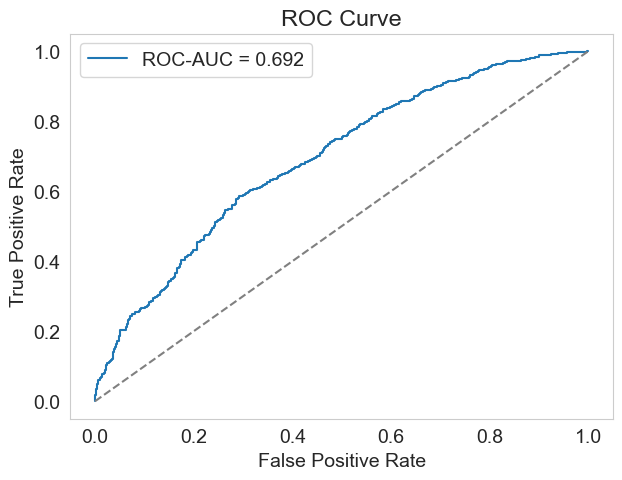

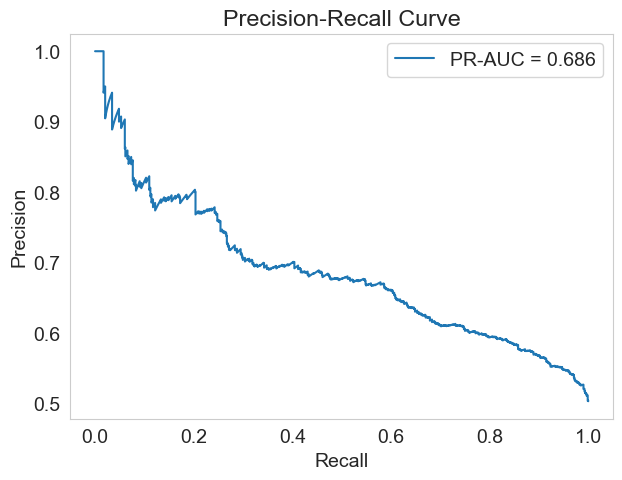

In [168]:
fpr, tpr, _ = roc_curve(y_test, proba_test)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, proba_test):.3f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure(figsize=(7,5))
plt.plot(rec, prec, label=f"PR-AUC = {average_precision_score(y_test, proba_test):.3f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

# Логистическая регрессия с небольшим подбором гиперпараметров

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__C': 1, 'clf__l1_ratio': 0.5, 'clf__penalty': 'l2'}


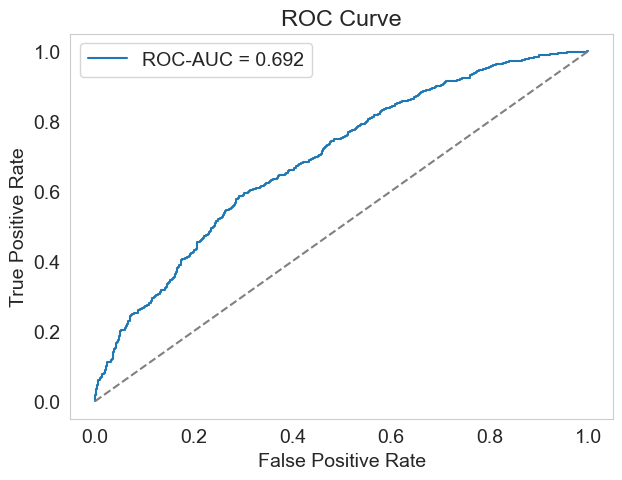

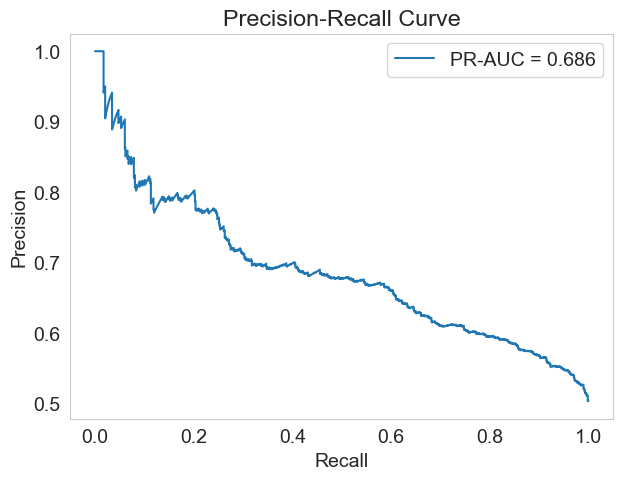

,threshold,F1,Precision,Recall,PR-AUC
0,0.1000,0.6868,0.5257,0.9903,0.6862
1,0.1889,0.6941,0.5429,0.9623,0.6862
2,0.2778,0.6985,0.5653,0.9138,0.6862
3,0.3667,0.6914,0.5904,0.8341,0.6862
4,0.4556,0.6620,0.6121,0.7209,0.6862
5,0.5444,0.6264,0.6655,0.5916,0.6862
6,0.6333,0.5259,0.6851,0.4267,0.6862
7,0.7222,0.3966,0.7270,0.2726,0.6862
8,0.8111,0.2286,0.7898,0.1336,0.6862
9,0.9000,0.1016,0.8929,0.0539,0.6862


Best threshold (max F1): 0.2777777777777778


,Metric,Train,Test
0,F1,0.752570,0.698517
1,Precision,0.612162,0.565333
2,Recall,0.976556,0.913793
3,ROC-AUC,0.910962,0.692497
4,PR-AUC,0.913781,0.686211


In [170]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=2000))
])

param_grid = {
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    # 'clf__solver': ['saga'],                 
    'clf__C': [  1, 2],
    'clf__l1_ratio': [ 0.5, 0.75] 
}

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)



proba_train = best_model.predict_proba(X_train)[:, 1]
proba_test  = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, proba_test)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, proba_test):.3f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure(figsize=(7,5))
plt.plot(rec, prec, label=f"PR-AUC = {average_precision_score(y_test, proba_test):.3f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

thresholds = np.linspace(0.1, 0.9, 10)
rows = []

for thr in thresholds:
    pred_train = (proba_train >= thr).astype(int)
    pred_test  = (proba_test >= thr).astype(int)
    
    rows.append([
        thr,
        f1_score(y_test, pred_test),
        precision_score(y_test, pred_test, zero_division=0),
        recall_score(y_test, pred_test),
        average_precision_score(y_test, proba_test)
    ])

thr_df = pd.DataFrame(rows, columns=["threshold", "F1", "Precision", "Recall", "PR-AUC"])
display(thr_df)

best_thr = thr_df.loc[thr_df["F1"].idxmax(), "threshold"]
print("Best threshold (max F1):", best_thr)



pred_train = (proba_train >= best_thr).astype(int)
pred_test  = (proba_test >= best_thr).astype(int)

metrics_table = pd.DataFrame({
    "Metric": ["F1", "Precision", "Recall", "ROC-AUC", "PR-AUC"],
    "Train": [
        f1_score(y_train, pred_train),
        precision_score(y_train, pred_train),
        recall_score(y_train, pred_train),
        roc_auc_score(y_train, proba_train),
        average_precision_score(y_train, proba_train)
    ],
    "Test": [
        f1_score(y_test, pred_test),
        precision_score(y_test, pred_test),
        recall_score(y_test, pred_test),
        roc_auc_score(y_test, proba_test),
        average_precision_score(y_test, proba_test)
    ]
})

display(metrics_table.style.set_caption("Final Model Metrics"))



,feature,coef,abs_coef
5824,nearest_park_name_Сквер у кинотеатра «Баку»,-1.5083,1.5083
4725,brand_Тануки,1.4720,1.4720
3563,name_Тануки,1.4720,1.4720
732,name_Hatimaki,1.4689,1.4689
4208,brand_Hatimaki,1.4689,1.4689
5761,"nearest_park_name_Сквер ""Молодёжный""",-1.3675,1.3675
4428,brand_Вкусно — и точка,-1.3623,1.3623
2043,name_Вкусно — и точка,-1.3623,1.3623
4813,brand_Шоколадница,-1.2925,1.2925
4021,name_Шоколадница,-1.2925,1.2925


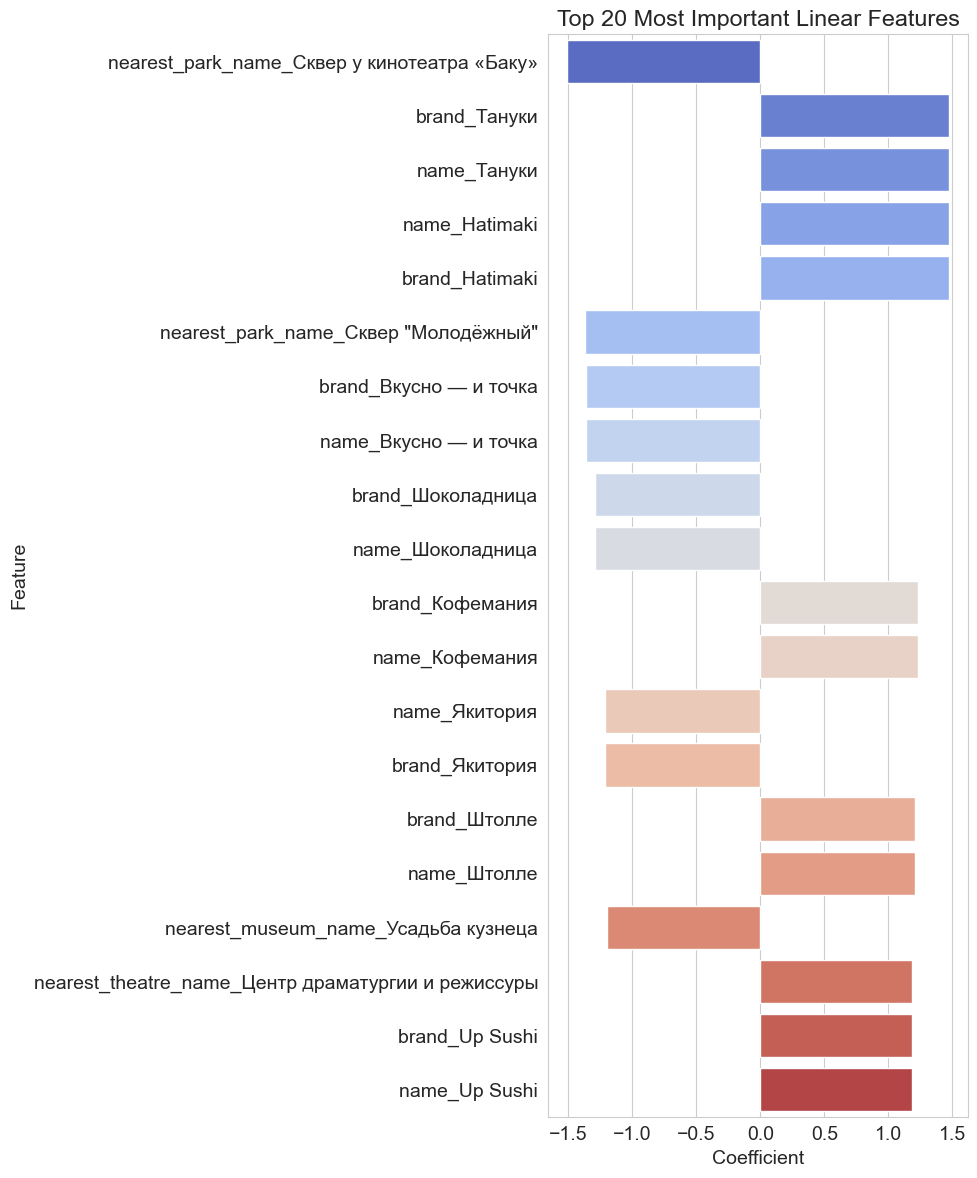

In [171]:
best_lr = best_model.named_steps["clf"]
preprocess = best_model.named_steps["preprocess"]

num_features = numeric_cols
cat_features = preprocess.named_transformers_["cat"].get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])

coefs = best_lr.coef_[0]

coef_df = pd.DataFrame({
    "feature": all_features,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

display(coef_df.head(50))

plt.figure(figsize=(10, 12))
sns.barplot(
    data=coef_df.head(20),
    x="coef",
    y="feature",
    palette="coolwarm"
)
plt.title("Top 20 Most Important Linear Features")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Линейная регрессия

Таргет - индекс успешности заведения, с учетом рейтинга и количества отзывов.

In [172]:
def get_target(df, m = 20, alpha = 1, beta = 1):
    rating_col = "dgis_general_rating" # колонка с рейтингом кафе R_i
    reviews_col = "dgis_general_review_count_with_stars" # колонка с числом
    # WR
    R = df[rating_col]
    v = df[reviews_col].fillna(0)
    C = R.mean() # средний рейтинг по всем кафе
    df["WR"] = (v / (v + m)) * R + (m / (v + m)) * C
    # Vol_i = log(1 + v_i)
    df["Vol"] = np.log1p(v) # log(1 + v_i)
    # cтандартизация BR и Vol
    WR_mean = df["WR"].mean()
    WR_std = df["WR"].std()
    Vol_mean = df["Vol"].mean()
    Vol_std = df["Vol"].std()
    df["zWR"] = (df["WR"] - WR_mean) / WR_std
    df["zVol"] = (df["Vol"] - Vol_mean) / Vol_std
    # итоговый таргет
    df["cafe_success_index"] = alpha * df["zWR"] + beta * df["zVol"]
    return df

final_df = get_target(final_df)

In [173]:
final_df

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m,nearest_gallery,nearest_gallery_name,other_attractions_100m,other_attractions_500m,other_attractions_1000m,parks_100m,parks_500m,parks_1000m,nearest_park,nearest_park_name,res_buildings_density_1000m,has_metro_500m,transport_count_500m,is_high_accessibility,has_business_nearby,has_education_nearby,has_medical_nearby,office_x_metro,education_x_transport,lat_cos,lon_sin,WR,Vol,zWR,zVol,cafe_success_index
0,Salden's Taphouse,bar,NaN,1,55.7656,37.6390,4.9000,129.0000,4.8000,252.0000,Москва,single,0,0,0,95,408,13,4,54,238,0.1735,0.3338,0.3437,2,16,78,0,3,13,0,5,33,172.8214,33.2176,1,3,7,0,0,0,1426.0186,1727.1819,3,24,78,0,6,24,7,95,389,34.0652,0,4,14,248.1845,"Музей ПАО ""Лукойл""",0,3,12,204.1419,Et Cetera,0,9,19,288.1633,Nadja Brykina Gallery,1,65,220,0,6,27,247.7801,Сквер «Огородная слобода»,132.4169,1,8,1,1,1,1,285,24,0.5626,0.6107,4.8074,4.8675,1.3338,0.6650,1.9988
1,Com,cafe,vietnamese,0,55.7683,37.6446,3.5000,12.0000,4.5000,164.0000,Москва,Com,1,3,0,47,293,5,0,0,0,0.7222,0.3636,0.3305,1,11,49,1,2,11,1,10,45,48.8885,286.3690,0,4,6,0,0,1,986.9986,2191.8871,0,12,76,0,7,25,2,82,295,43.8452,0,0,8,561.7504,Музей-квартира А.М. Васнецова,0,1,16,447.7947,Московский театр Олега Табакова,0,1,12,346.8317,Sare art,1,73,179,2,9,32,42.0326,(без названия),113.9549,1,14,1,1,1,1,328,28,0.5625,0.6108,3.9437,2.5649,-0.7947,-0.8176,-1.6124
2,Шоколадница,cafe,coffee_shop,1,55.7388,37.6530,2.4000,170.0000,3.1000,10899.0000,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.3333,0.1630,0.2624,0,11,23,0,4,10,3,27,56,29.4159,196.7578,0,3,3,0,0,0,1317.2032,2918.2772,0,15,52,0,5,23,0,28,175,105.7705,0,2,9,399.3420,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.4166,Театр на Таганке,0,1,2,305.4466,Краснохолмская,0,16,50,1,2,8,91.9965,(без названия),56.6592,1,30,1,1,1,1,84,120,0.5630,0.6109,2.5905,5.1417,-4.1298,0.8415,-3.2883
3,Тануки,restaurant,japanese,1,55.7285,37.6792,4.9000,527.0000,4.8000,24921.0000,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.0000,0.2200,0.1844,0,2,18,0,3,5,2,9,38,35.0965,607.6404,0,0,3,0,0,1,941.1361,4915.1678,0,7,23,1,6,17,0,6,34,260.9520,1,1,1,82.2060,Музей Русской Культуры,0,1,2,486.6218,Театр на Мельникова,0,0,0,1459.1371,Здесь на Таганке,2,4,12,0,0,7,509.9739,(без названия),46.7916,0,9,1,1,1,1,0,27,0.5631,0.6112,4.8748,6.2691,1.4999,1.5674,3.0673
4,Вареничная №1,restaurant,russian,1,55.7322,37.6651,4.1000,201.0000,4.1000,3881.0000,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.1250,0.1967,0.2683,2,11,34,0,2,7,2,19,54,55.2170,61.6990,1,2,2,0,0,0,1552.3689,3974.4183,0,12,37,0,4,24,2,17,63,85.3608,0,0,5,554.3952,Усыпальница бояр Романовых,0,1,3,449.9650,Московский детский театр марионеток,0,0,1,984.1620,Краснохолмская,0,7,30,0,2,9,191.1152,(без названия),69.7099,1,21,1,1,1,1,34,42,0.5631,0.6110,4.1100,5.3083,-0.385

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'model': Ridge(), 'model__alpha': 5, 'model__max_iter': 1000}


,Metric,Train,Test
0,RMSE,0.264771,0.396550
1,MAE,0.401348,0.487343
2,R²,0.526690,0.268651


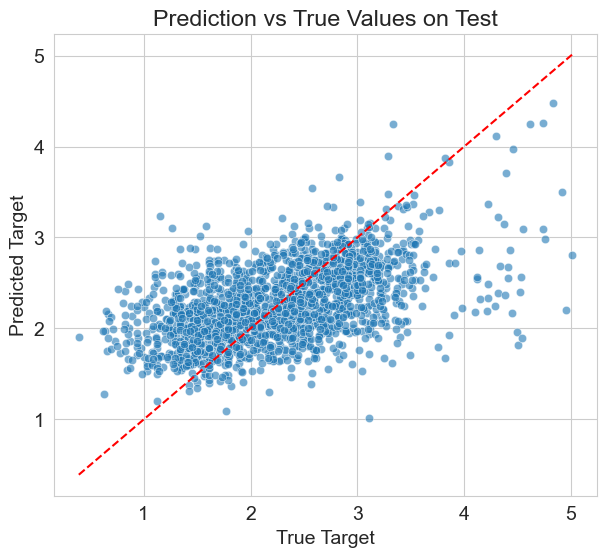

In [174]:
y = final_df["cafe_success_index"]

drop_cols = ["cafe_success_index", "dgis_general_rating", "dgis_general_review_count_with_stars", 
             "WR", "Vol", "zWR", "zVol", 'website', 'cuisine', 'dgis_org_rating', 'dgis_org_review_count', 'lan', 'lon']  
X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# cчитаем min/max только по train
y_min = y_train.min()
y_max = y_train.max()

# преобразуем train и test в [0, 5]
def scale_to_0_5(y, y_min, y_max):
    return 5 * (y - y_min) / (y_max - y_min)

y_train = scale_to_0_5(y_train, y_min, y_max)
y_test  = scale_to_0_5(y_test,  y_min, y_max)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ])


pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge())   
])

param_grid = {
    "model": [Ridge(), Lasso(), ElasticNet()],
    
    "model__alpha": [1, 3, 5],

    "model__max_iter": [1000, 3000]    
}


grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Best params:", grid.best_params_)



pred_train = best_model.predict(X_train)
pred_test  = best_model.predict(X_test)



metrics = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R²"],
    "Train": [
        mean_squared_error(y_train, pred_train),
        mean_absolute_error(y_train, pred_train),
        r2_score(y_train, pred_train)
    ],
    "Test": [
        mean_squared_error(y_test, pred_test),
        mean_absolute_error(y_test, pred_test),
        r2_score(y_test, pred_test)
    ]
})

display(metrics.style.set_caption("Regression Performance Metrics"))


plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")
plt.title("Prediction vs True Values on Test")
plt.show()

Количество признаков: 5895
Количество коэффициентов: 5895


,feature,coef,abs_coef
643,name_Frank by Баста,0.9384,0.9384
4194,brand_Frank by Баста,0.9384,0.9384
2528,name_Корчма,0.7603,0.7603
4512,brand_Корчма,0.7603,0.7603
1958,name_Бутчер,0.6332,0.6332
4407,brand_Бутчер,0.6332,0.6332
385,name_Chicko,0.5188,0.5188
4138,brand_Chicko,0.5188,0.5188
1534,name_The Бык,0.5128,0.5128
4342,brand_The Бык,0.5128,0.5128


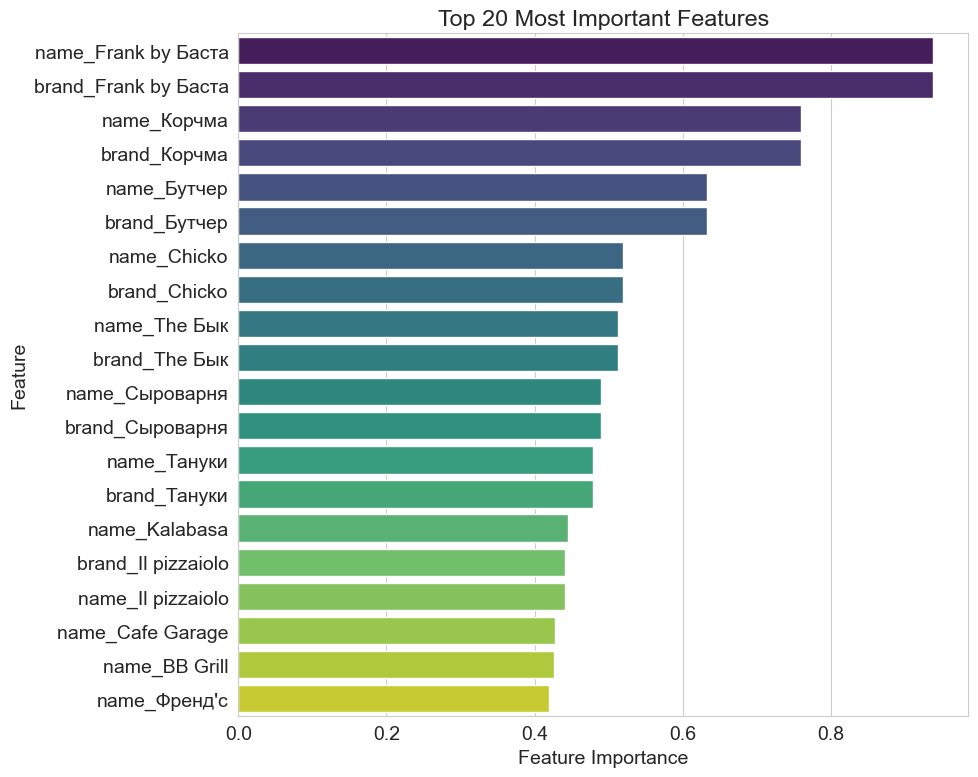

In [175]:
best_model = grid.best_estimator_
reg = best_model.named_steps["model"]

pre = best_model.named_steps["preprocess"]
num_features = pre.named_transformers_["num"].get_feature_names_out(numeric_cols)
cat_encoder = pre.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])
coefs = reg.coef_.flatten()

print("Количество признаков:", len(all_features))
print("Количество коэффициентов:", len(coefs))

importance_df = pd.DataFrame({
    "feature": all_features,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
})

importance_df = importance_df.sort_values("abs_coef", ascending=False)

display(importance_df.head(20))
top_n = 20
top_imp = importance_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_imp,
    x="abs_coef",
    y="feature",
    orient="h",
    palette="viridis"
)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Most Important Features")
plt.tight_layout()
plt.show()

# Выводы

И при решении задачи регрессии, и при классификации линейные модели не обращает внимание на признаки, которые мы насоздали с количеством и расстоянием. Главная фича - название бренда. Бенчмарк очень низкий, надеюсь, нелинейными моделями его немного побьем, есть что улучшать:) Возможно, слишком много фичей наплодилось, а объектов не так много, и модельки путаются.